# NTSB Feature Selection

This notebook examines the rates of missingness for each value in the master NTSB dataset, as well as population for dummy variables, allowing us to pare down features which may not be likely to be useful/predictive.

### Note: 
This notebook employs the **'missingno'** package, which can be installed with a "pip install missingno" command in your Terminal.
***


In [2]:
import pandas as pd
import missingno as mno
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
data = pd.read_csv("../data/ntsb/cleaned/master_train.csv")

data = data.loc[(data['ev_country']=='USA') & (data['ev_type']=='ACC')] # Limit to US accidents 
data.drop(columns=['ev_country', 'ev_type'], inplace=True)

data = data.loc[~data['inj_tot_t'].isna()]
## clean more : impute ground injury values
data[['inj_f_grnd', 'inj_m_grnd', 'inj_s_grnd']]= data[['inj_f_grnd', 'inj_m_grnd', 'inj_s_grnd']].fillna(0) 
data['ground_injury_total'] = data[['inj_f_grnd', 'inj_m_grnd', 'inj_s_grnd']].sum(axis=1)

### Drop columns we don't need

#### Notes 
- Since we don't want to drop columns based on their frequency in the test set, this is probably a temporary measure to simplify our exploration, but we can take it out once we have a model
- The following should be run __before__ drop infrequent values, which fills in missing entries

In [292]:
## Show columns where the proportion of non-empty entries is less than 0.8

for col in data.columns:
    pna = data[col].isna().sum() / len(data)
    if pna > 0.2 :
        print(col, round(pna,3))



on_ground_collision 0.974
wind_vel_kts 0.212
owner_acft 0.423
oprtng_cert 1.0
oper_cert 1.0
evacuation 1.0
rwy_len 0.472
rwy_width 0.474
acft_year 0.513
fuel_on_board 0.708


In [293]:
def drop_sparse_columns(data, threshold, safe_cols=None):
    '''
    Drops columns from data that do not contain at least a given proportion of non-empty entries
    
    Inputs
        data: pandas DataFrame
        threshold: float in [0,1], all columns with less than this proportion of non-empty entries are dropped
        safe_cols: list of names of columns that should not be dropped even if they are below the sparsity threshold
    Outputs
        data: same DataFrame with appropriate columns dropped
    '''
    # list of columns to drop if they are too sparse
    unsafe_cols = [col for col in data.columns if col not in safe_cols]

    for col in unsafe_cols:
        # calculate proportion of na entries in col
        prop_na = data[col].isna().sum() / len(data)
        
        # drop col if the column is too sparse
        if prop_na > 1 - threshold:
            data.drop(columns=col, inplace=True)
    
    return data

In [294]:
data = drop_sparse_columns(data, 0.8, safe_cols=['damage', 'acft_category', 'acft_make', 'acft_model'])

In [295]:
# Already processed
data.drop(columns=['Aircraft', 'Aircraft_Key', 'ev_id', 'finding_description'], inplace=True)

# Possible data leakage
data.drop(columns=['acft_fire', 'acft_expl'], inplace=True)

# Probably not relevant (ev_time seemingly boils down to light_cond)
data.drop(columns=['wx_dew_pt', 'type_fly', 'ev_time'], inplace=True)

# (Almost) all rows have same value
data.drop(columns=['certs_held', 'unmanned'], inplace=True)

### Handling missing values

Eventually when we impute values, I think we should do so __before__ dropping any columns / infrequent values of categorical variables because we may use that information in imputation even if we don't use it in modeling. E.g. if we only two occurences of a particular aircraft model, that could still be useful for imputing missing info about the aircraft.

#### `total_person_count`
We have some missing data for `total_person_count`, which can mostly be calculated, but:
1. there are a few (~10) cases where we're missing data for both aircraft in a multi-aircraft event. 
2. if `inj_tot_t` and aircraft-level counts are missing and the other event-level injury counts are 0, this does not necessarily indicate that there were only unmanned aircraft involved. It seems that the other event-level injury counts default to 0 when they are unknown, and only `inj_tot_t` is left blank in the dataset.

I found the following reasons why the injury counts might be unknown:
- Crash occurred outside of the USA --> no NTSB investigation
- Incident and not accident --> superficial investigation
- Aircraft damage was discovered in an inspection --> investigation could not determine whether injuries occurred

#### Filtering data
- I think we should filter out (a) events outside the USA and (b) non-accidents because of a high likelihood of sparse data. This leaves us with ~83% of the data. 
- If we do this, most of the variables now have well over 80% of the values present
- My gut is to filter before the train-test split, but I'm not certain that's right (or that it matters)

#### Other notes
- Oddly, `gust_kts` is 100% present but `wind_vel_kts` is ~20% missing. When `wind_vel_kts` is missing, `gust_kts` is 0 more than 99% of the time, which probably means that 0 is entered by default when it's unknown

### Imputing values

Categorical
- Target variables (does it ever make sense to impute a target variable, or should we just omit from the dataset / performance metrics?)
  - `damage`: guess based on injury severity 
  - `ev_highest_injury`: calculate from injury counts
- All others: 'other/unknown'

Numerical
- Calculate from other data: `total_person_count`, `Minor_count`, `None_count`, `Serious_count`, `Fatal_count`, `injured_person_count`, `ev_highest_injury`, `inj_tot_t`
- `latitude`, `longitude`: randomly sample? (not a huge issue -- it's only 1 row)
- `Environmental issues`, `Organizational issues`, `Personnel issues`: impute 0
- `num_eng`: find max number of passengers on a 1-engine aircraft, impute 1 for aircraft with at most this many passengers, 2 for aircraft with more passengers

In [296]:
## Imputing `damage` value
## Since approximately 3.9% of the entries in the damage column are missing, we choose to drop these rows.
data = data.loc[~data['damage'].isna()]

In [297]:
## Imputing other categorical values

for col in data.columns:
    mask = data[col].isna()
    if any(mask) and data[col].dtype == 'object':
        data.loc[mask,col] = data[mask][col].replace(np.nan,'other/unknown')

In [300]:
## Imputing findings

data[['Environmental issues', 'Organizational issues', 'Personnel issues']] = data[['Environmental issues', 'Organizational issues', 'Personnel issues']].fillna(0)

In [314]:
## Imputing total person count
## There are only four event_key ['20080505X00589_2', '20130118X53100_2' , '20160218X94149_2', '20170913X72254_2']
## Whatever the exact circumstances (e.g., parked at the airport or taxiing), there were no occupants in these second aircraft, as all reported injuries (inj_tot_t) are attributed to the first aircraft in each event.
count = ['event_key', 'Fatal_count', 'Minor_count', 'None_count', 'Serious_count', 'total_person_count', 'injured_person_count','ground_injury_total', 'inj_tot_t']
data.loc[data['total_person_count'].isna(),count] = data[data['total_person_count'].isna()][count].fillna(0)

,ntsb_no,ev_year,ev_month,latitude,longitude,apt_dist,light_cond,gust_kts,altimeter,ev_highest_injury,...,Environmental issues,Organizational issues,Personnel issues,Fatal_count,Minor_count,None_count,Serious_count,total_person_count,injured_person_count,ground_injury_total


In [361]:
data.loc[data['ntsb_no'] == 'ANC08LA095','total_seats'] = 6 ## By searching for T210
data.loc[data['ntsb_no'] == 'CEN09CA474','total_seats'] = 6 ## By the number of person and search (6 - 11)
data.loc[data['ntsb_no'] == 'WPR10LA313','total_seats'] = 4 ## By searching for DHC-1


In [389]:
## For aircrafts having single engine, data shows the number of seats is less than 20.
print(np.max(data[data['num_eng']==1]['total_seats'].fillna(0).values))

## Imputing value 1 into 'num_eng' if the total seats is less than 20.
data.loc[(data['num_eng'].isna())& (data['total_seats']<=20), 'num_eng'] = data[(data['num_eng'].isna())& (data['total_seats']<=20)]['num_eng'].fillna(1)

## There are only four cases both blank.
## All have two engines typically.
print(data[(data['num_eng'].isna())& (data['total_seats'].isna()) & (data['total_person_count']>20)][['event_key','acft_model']])

data.loc[(data['num_eng'].isna())& (data['total_seats'].isna()), 'num_eng'] = data[(data['num_eng'].isna())& (data['total_seats'].isna())]['num_eng'].fillna(2)

20.0
              event_key acft_model
9803   20141217X43728_1        737
9992   20150305X42958_1      MD 88
10933  20151029X44249_1        767
15294  20190304X65511_1     EMB145


In [398]:
## And other cases have two engines typically.

data.loc[data['num_eng'].isna(), 'num_eng'] = data[data['num_eng'].isna()]['num_eng'].fillna(2)

np.float64(4.0)

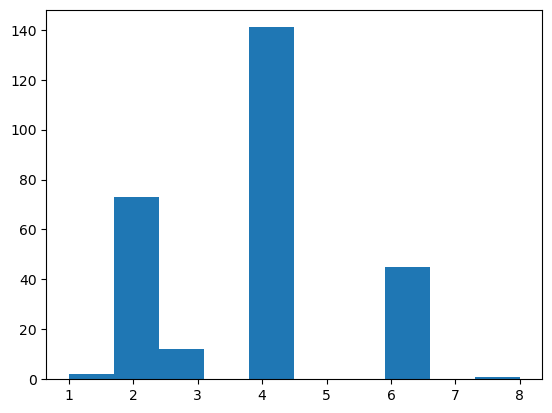

In [399]:
## While the total number of seats could potentially be inferred from other data sources or looked up online, doing so would be time-consuming.
plt.hist(data[(data['far_part'] == '091' )& (data['acft_make'] == 'Piper') &(data['num_eng'] == 1.0) ]['total_seats'].values)
np.mean(data[(data['far_part'] == '091' )& (data['acft_make'] == 'Piper') &(data['num_eng'] == 1.0) & (~data['total_seats'].isna()) ]['total_seats'].values).round()


In [401]:
##Check whether additional imputations are needed except for the 'total_seats' column.

for col in data.columns:
    mask = data[col].isna()
    if any(mask):
        print(col)

total_seats


### Category reduction for categorical variables

#### Manual category reduction

Before we reduce infrequent values to 'other/unknown', there may be cases where we can combine categories in a more intelligent way:
- BroadPhaseOfFlight (what happened to this variable?)
- `acft_category`: group based on size?
- `far_part`: would require some research
- `light_cond`: maybe combine all conditions other than DAYL and NITE into a 'partial light' category (would have to check what all of the abbreviations mean)

#### Automated category reduction

We'll reduce categories by reassigning all categories with frequency $< \alpha$ to 'other/unknown' (for some $\alpha \in [0.01, 0.05]$)

Note: when we go to build the model, we'll have to make sure we're reducing categories based on their frequency in the training set and NOT based on their frequency in the test set

In [50]:
def reduce_categories_fill_na(data, columns, threshold):
    '''
    For each of the specified columns, find the values that occur with frequency lower than the threshold,
    and replace these values and missing values by 'other/unknown'.
    This is only intended for categorical variables
    
    Inputs
        data: pandas DataFrame
        columns: list of column names to simplify
        threshold: float in [0,1], frequency threshold for removing 
    Outputs
        data: pandas DataFrame
    '''

    freq_thresh = threshold * len(data)

    for col in columns:
        counts = data[col].value_counts()
        
        for i in counts.index:
            if counts[i] < freq_thresh:
                data.loc[data[col]==i, col] = 'other/unknown'
        
        data.loc[data[col].isna(), col] = 'other/unknown'

    return data

In [82]:
categorical_vars = ['light_cond', 'eng_type', 'far_part', 'acft_make', 'acft_category',
                    'homebuilt', 'fixed_retractable', 'second_pilot']
# Note: intentionally omitted 'ntsb_no', 'ev_highest_injury', 'Aircraft_ID', 'event_key', 
#                               'damage', 'acft_model'

data = reduce_categories_fill_na(data, categorical_vars, 0.01)

In [88]:
data.columns

Index(['ntsb_no', 'ev_year', 'ev_month', 'latitude', 'longitude', 'apt_dist',
       'light_cond', 'gust_kts', 'altimeter', 'ev_highest_injury', 'inj_tot_f',
       'inj_tot_m', 'inj_tot_n', 'inj_tot_s', 'inj_tot_t', 'aircraft_count',
       'Aircraft_ID', 'event_key', 'eng_type', 'far_part', 'damage',
       'acft_make', 'acft_model', 'acft_category', 'homebuilt', 'total_seats',
       'num_eng', 'fixed_retractable', 'date_last_insp', 'second_pilot',
       'Environmental issues', 'Organizational issues', 'Personnel issues',
       'Fatal_count', 'Minor_count', 'None_count', 'Serious_count',
       'total_person_count', 'injured_person_count'],
      dtype='object')

### Feature engineering

In [40]:
# Calculate number of people onboard and the proportion in each injury level

data['num_people_onboard'] = data['inj_tot_f'] + data['inj_tot_m'] + data['inj_tot_n'] + data['inj_tot_s']
data['prop_onboard_inj'] =  (data['num_people_onboard'] - data['inj_tot_n'])/ data['num_people_onboard']
data['prop_onboard_inj_m'] =  data['inj_tot_m'] / data['num_people_onboard']
data['prop_onboard_inj_s'] =  data['inj_tot_s'] / data['num_people_onboard']
data['prop_onboard_inj_f'] =  data['inj_tot_f'] / data['num_people_onboard']